In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import jarque_bera as jb
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings


In [124]:
# Access database and gather information
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_data = pd.read_sql_query('select * from lifeexpectancy', con=engine)

engine.dispose()

life_data.info()
life_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [125]:
# Create fill list of objects with nulls
fill_list = []

for col in life_data:
  if life_data[col].count() != 2938:
    fill_list.append(col)
 # Remove value that is already full


#interpolate and fill missing values
for col in fill_list:
  life_data.loc[:,col] = life_data.loc[:,col].interpolate()

life_data.info()
fill_list

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2938 non-null   float64
 4   Adult Mortality                  2938 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2938 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2938 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2938 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

['Life expectancy ',
 'Adult Mortality',
 'Alcohol',
 'Hepatitis B',
 ' BMI ',
 'Polio',
 'Total expenditure',
 'Diphtheria ',
 'GDP',
 'Population',
 ' thinness  1-19 years',
 ' thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

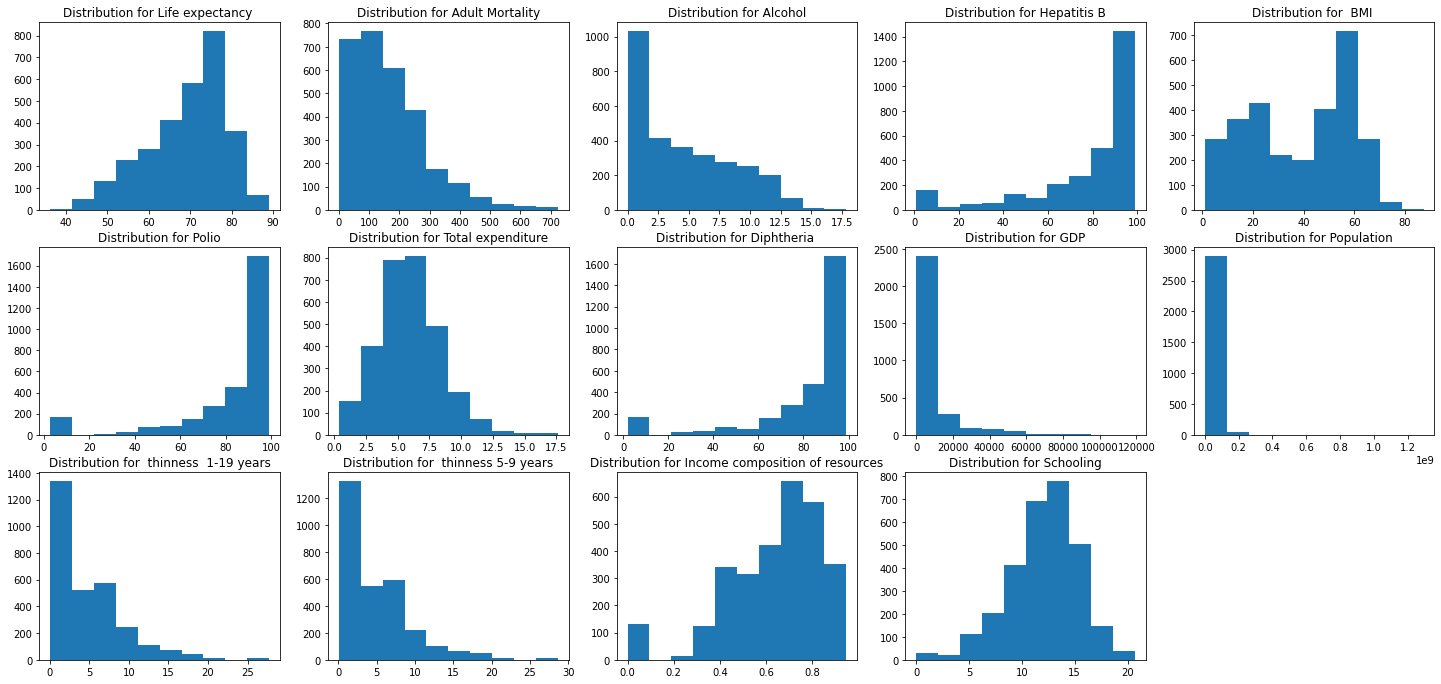

In [126]:
# create histograms for visualization
plt.figure(figsize=(25,20))
x = 1
for col in fill_list:
  plt.subplot(5,5,x)
  plt.hist(life_data[col])
  plt.title('Distribution for {}'.format(col))
  x = x +1
plt.show()

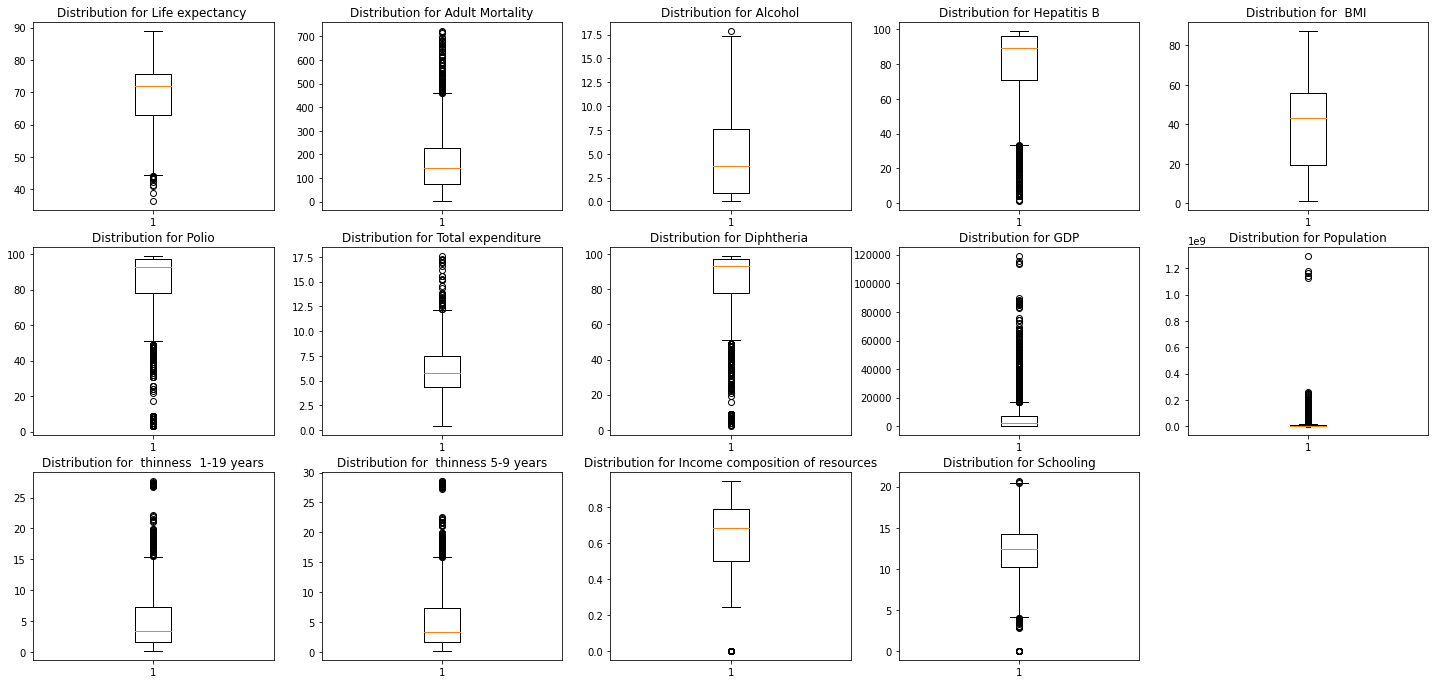

In [127]:
# create boxplots for visualization
x = 1
plt.figure(figsize=(25,20))
for col in fill_list:
  plt.subplot(5,5,x)
  plt.boxplot(life_data[col])
  plt.title('Distribution for {}'.format(col))
  x = x +1
plt.show()

In [0]:
# After examining both the histograms and the boxplots we see that there
# are outliers. Turkey's method should allow us to check

# Create method to find outliers
def turkeys_method(data):
  q75 = np.percentile(data, 75)
  q25 = np.percentile(data, 25)
  iqr = q75 - q25
  for threshold in np.arange(1,5,.5):
    min_val = q25 - (iqr * threshold)
    max_val = q75 + (iqr * threshold)
    print('The threshold is: {}'.format(threshold))
    print("Number of outliers is: {}".format(len((np.where((data > max_val) | (data < min_val))[0]))))

In [130]:
# Use Turkey's Method to find potential outliers
for col in fill_list:
  print('\nTurkeys Method outliers for {}'.format(col))
  turkeys_method(life_data[col])


Turkeys Method outliers for Life expectancy 
The threshold is: 1.0
Number of outliers is: 138
The threshold is: 1.5
Number of outliers is: 12
The threshold is: 2.0
Number of outliers is: 1
The threshold is: 2.5
Number of outliers is: 0
The threshold is: 3.0
Number of outliers is: 0
The threshold is: 3.5
Number of outliers is: 0
The threshold is: 4.0
Number of outliers is: 0
The threshold is: 4.5
Number of outliers is: 0

Turkeys Method outliers for Adult Mortality
The threshold is: 1.0
Number of outliers is: 176
The threshold is: 1.5
Number of outliers is: 82
The threshold is: 2.0
Number of outliers is: 40
The threshold is: 2.5
Number of outliers is: 20
The threshold is: 3.0
Number of outliers is: 5
The threshold is: 3.5
Number of outliers is: 0
The threshold is: 4.0
Number of outliers is: 0
The threshold is: 4.5
Number of outliers is: 0

Turkeys Method outliers for Alcohol
The threshold is: 1.0
Number of outliers is: 18
The threshold is: 1.5
Number of outliers is: 1
The threshold is:

In [132]:
#there seem to be quite a few outliers. winsorize should handle this

#create a new dataframe as to not affect the original
life_data_winsorized = life_data.copy()

# for each of the columns in fill_list, wisorize the data, and run
# turkeys_method to check that outliers have been removed
for col in fill_list:
  life_data_winsorized[col] = winsorize(life_data[col], (.15,.15))
  print('\nWinsorized data for: {}'.format(col))
  turkeys_method(life_data_winsorized[col])  


Winsorized data for: Life expectancy 
The threshold is: 1.0
Number of outliers is: 0
The threshold is: 1.5
Number of outliers is: 0
The threshold is: 2.0
Number of outliers is: 0
The threshold is: 2.5
Number of outliers is: 0
The threshold is: 3.0
Number of outliers is: 0
The threshold is: 3.5
Number of outliers is: 0
The threshold is: 4.0
Number of outliers is: 0
The threshold is: 4.5
Number of outliers is: 0

Winsorized data for: Adult Mortality
The threshold is: 1.0
Number of outliers is: 0
The threshold is: 1.5
Number of outliers is: 0
The threshold is: 2.0
Number of outliers is: 0
The threshold is: 2.5
Number of outliers is: 0
The threshold is: 3.0
Number of outliers is: 0
The threshold is: 3.5
Number of outliers is: 0
The threshold is: 4.0
Number of outliers is: 0
The threshold is: 4.5
Number of outliers is: 0

Winsorized data for: Alcohol
The threshold is: 1.0
Number of outliers is: 0
The threshold is: 1.5
Number of outliers is: 0
The threshold is: 2.0
Number of outliers is: 0


In [0]:
#Create method to compare original histograms and boxplots with the winsorized
# version of the array.
def show_winsor(data_1, data_2, variable):
  plt.figure(figsize= (15,5))
  plt.subplot(1,2,1)
  plt.boxplot(data_1)
  plt.title('{} distribution'.format(variable))
  plt.subplot(1,2,2)
  plt.boxplot(data_2)
  plt.title('{} distribution (winsorized)'.format(variable))

# Method that creates historgrams to show change in distribution after applying
# boxcox transformation
def show_transform(data, variable):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.hist(data)
  plt.title('{} distribution'.format(variable))
  plt.subplot(1,2,2)
  boxcox_transform,_ = boxcox(data)
  plt.hist(boxcox_transform)
  plt.title('{} distribution (transformed)'.format(variable))
  print('Normality test for {}: {}'.format(variable , stats.shapiro(boxcox_transform)))

In [0]:
# Previously wisorized the life_data dataframe saved as life_data_winsorized,
# will use show_winsor to see if the winsorization eliminiated outliers
for col in fill_list:
  show_winsor(life_data[col], life_data_winsorized[col], col)

Normality test for Life expectancy : (0.9258666038513184, 7.649375950505897e-36)
Normality test for Adult Mortality: (0.9040674567222595, 1.4902010427969764e-39)
Normality test for Alcohol: (0.7923110723495483, 0.0)
Normality test for Hepatitis B: (0.571517825126648, 0.0)
Normality test for  BMI : (0.8367801904678345, 0.0)
Normality test for Polio: (0.48176145553588867, 0.0)
Normality test for Total expenditure: (0.945556640625, 1.191521628548574e-31)
Normality test for Diphtheria : (0.4885784387588501, 0.0)
Normality test for GDP: (0.9913806319236755, 2.7145343264867172e-12)
Normality test for Population: (0.9797658920288086, 4.7546554867049705e-20)
Normality test for  thinness  1-19 years: (0.970395565032959, 3.535945945351971e-24)
Normality test for  thinness 5-9 years: (0.9675399661064148, 3.0708279349997127e-25)


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: ignored

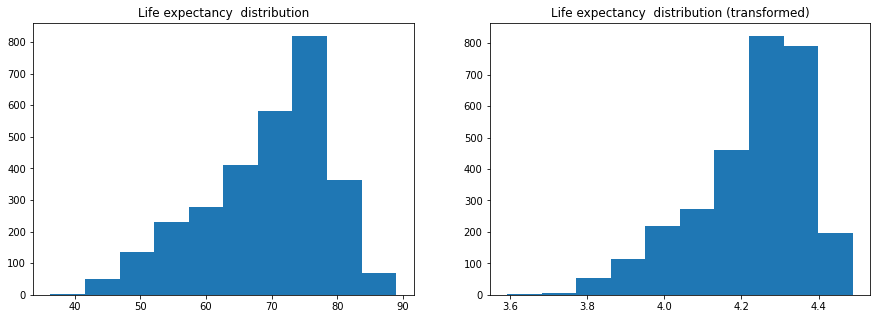

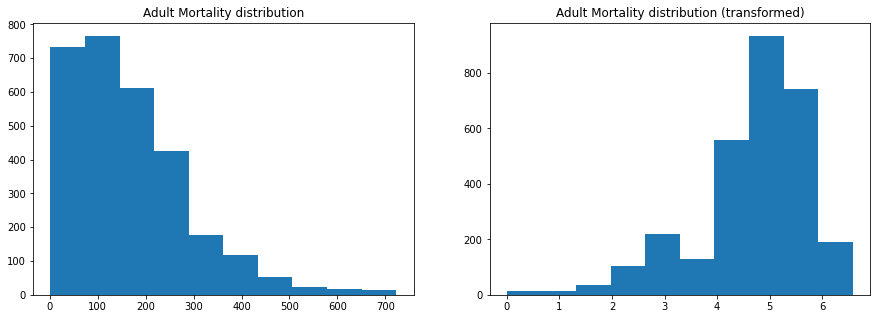

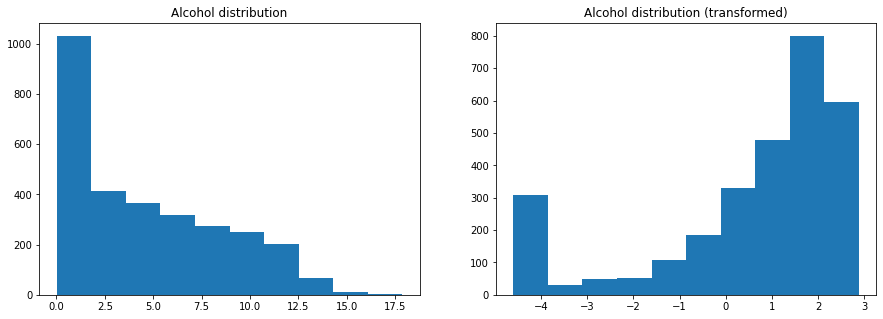

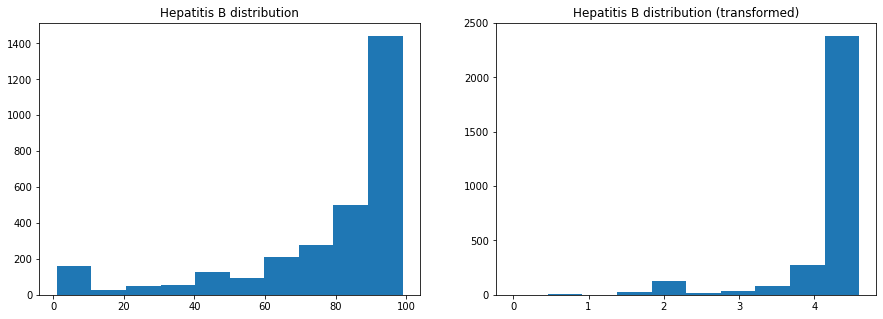

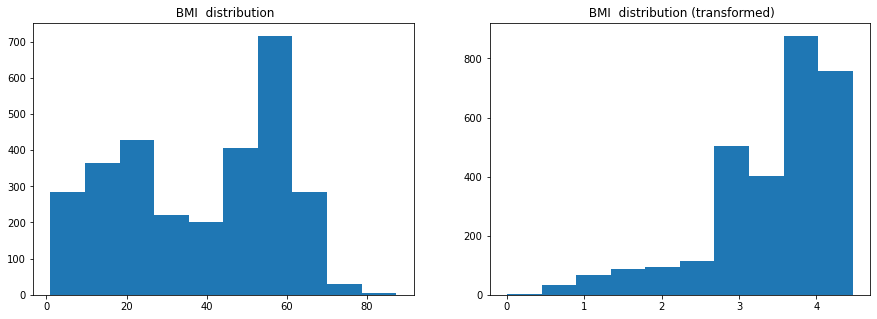

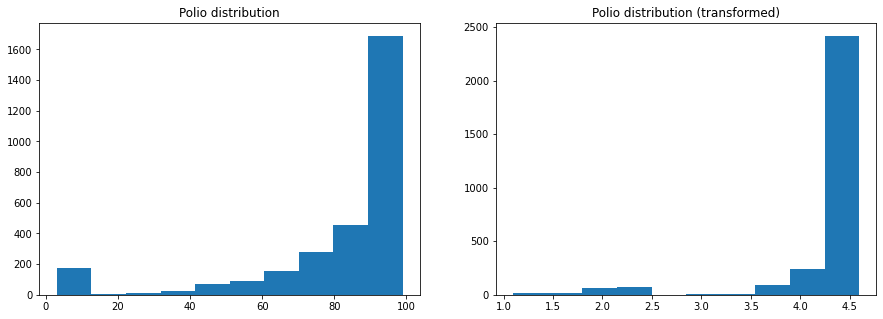

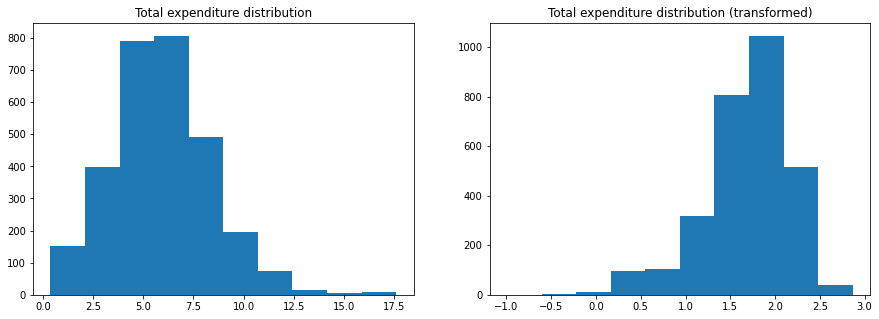

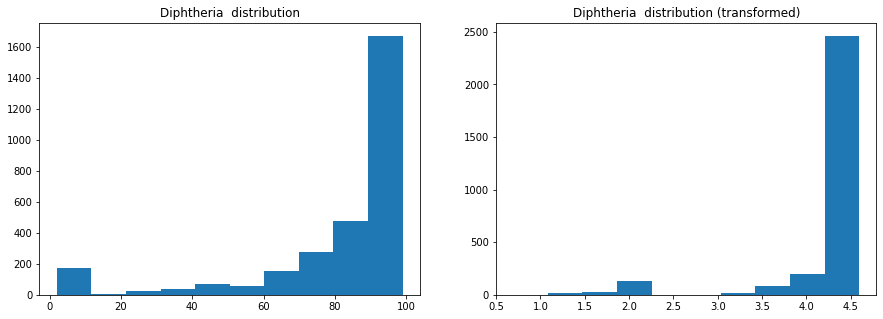

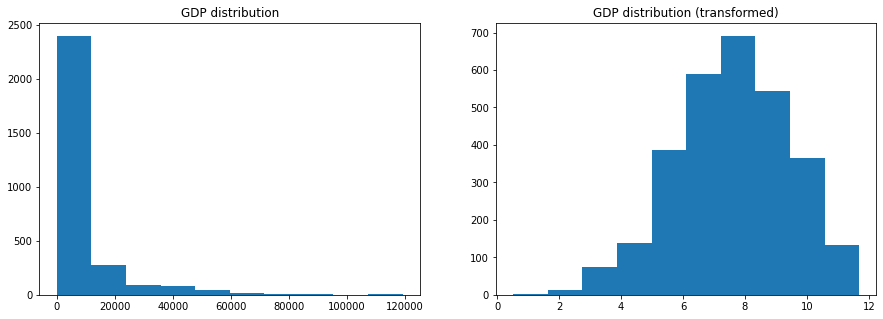

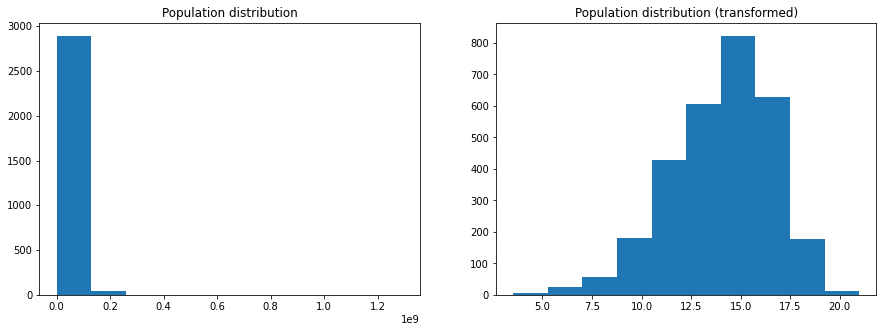

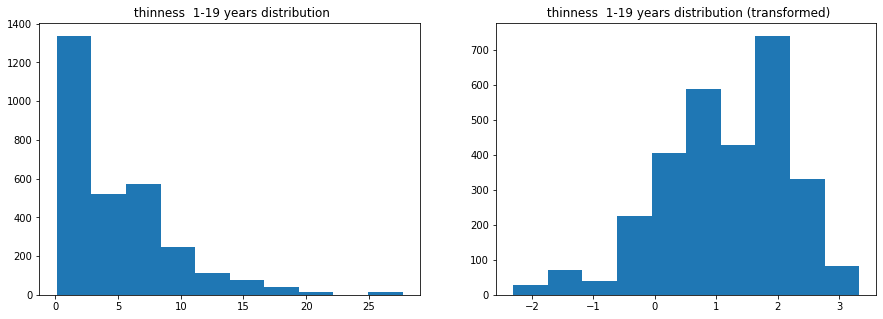

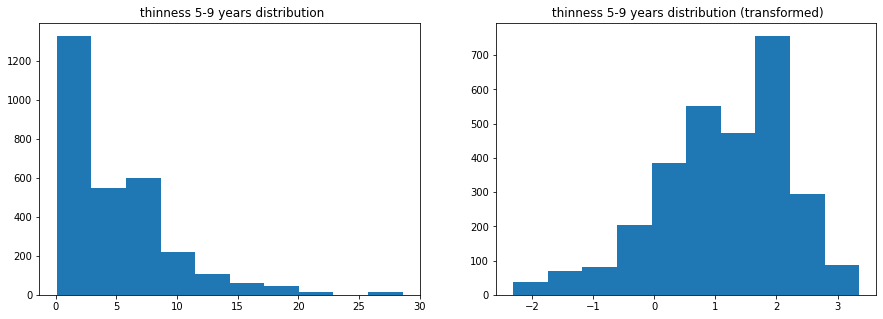

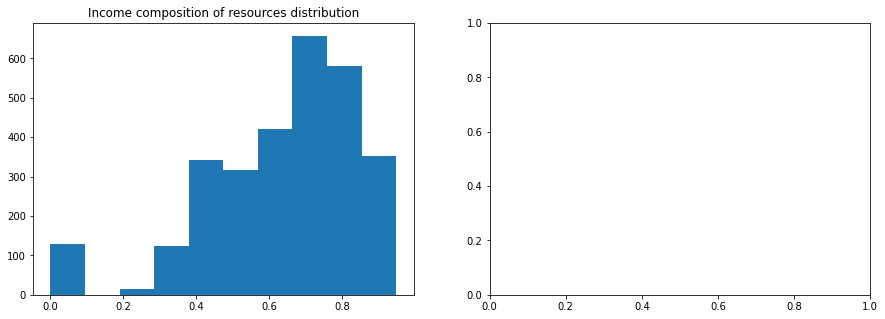

In [146]:
# Now that the columns have no outliers, make sure that their distributions are 
# so they'll be easier to use in PCA.

# For each col in the fill_list, use the show_transfrom method and check for
# normal distribution after transform using Shapiro test.
for col in fill_list:
  show_transform(life_data[col], col)

In [0]:
#univariate analysis
life_data.describe()
 
 # We can see from .describe that the life expectancy cross all 
 # variables averages to about 69.55
 

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.557897,151.631892,30.303948,4.299267,738.251295,82.271145,2419.592240,38.678972,42.035739,87.062376,5.873402,86.885102,1.742103,4590.361400,4.911251e+06,4.317080,4.316014,0.652670,12.222924
std,4.613841,7.340431,87.245867,117.926501,3.479238,1987.914858,16.553551,11467.272489,17.312339,160.445548,11.819688,1.740725,12.007733,5.077785,5065.001435,6.042158e+06,2.910485,2.927885,0.145150,2.340037
min,2000.000000,57.700000,35.000000,0.000000,0.200000,0.000000,52.000000,0.000000,15.400000,0.000000,66.000000,3.500000,65.000000,0.100000,321.481324,9.238353e+04,1.100000,1.000000,0.434000,8.700000
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,71.000000,0.000000,19.325000,0.000000,78.000000,4.312500,78.000000,0.100000,553.618620,2.536025e+05,1.600000,1.600000,0.500000,10.200000
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.250000,4.000000,93.000000,5.760000,93.000000,0.100000,2192.681084,1.576319e+06,3.400000,3.400000,0.684000,12.400000
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.100000,28.000000,97.000000,7.440000,97.000000,0.800000,7183.381694,8.215738e+06,7.200000,7.300000,0.791107,14.300000
max,2015.000000,78.300000,284.000000,1800.000000,9.620000,19479.911610,98.000000,212183.000000,59.100000,2500.000000,98.000000,8.430000,98.000000,50.600000,14223.865760,1.642558e+07,8.800000,8.800000,0.831163,15.400000


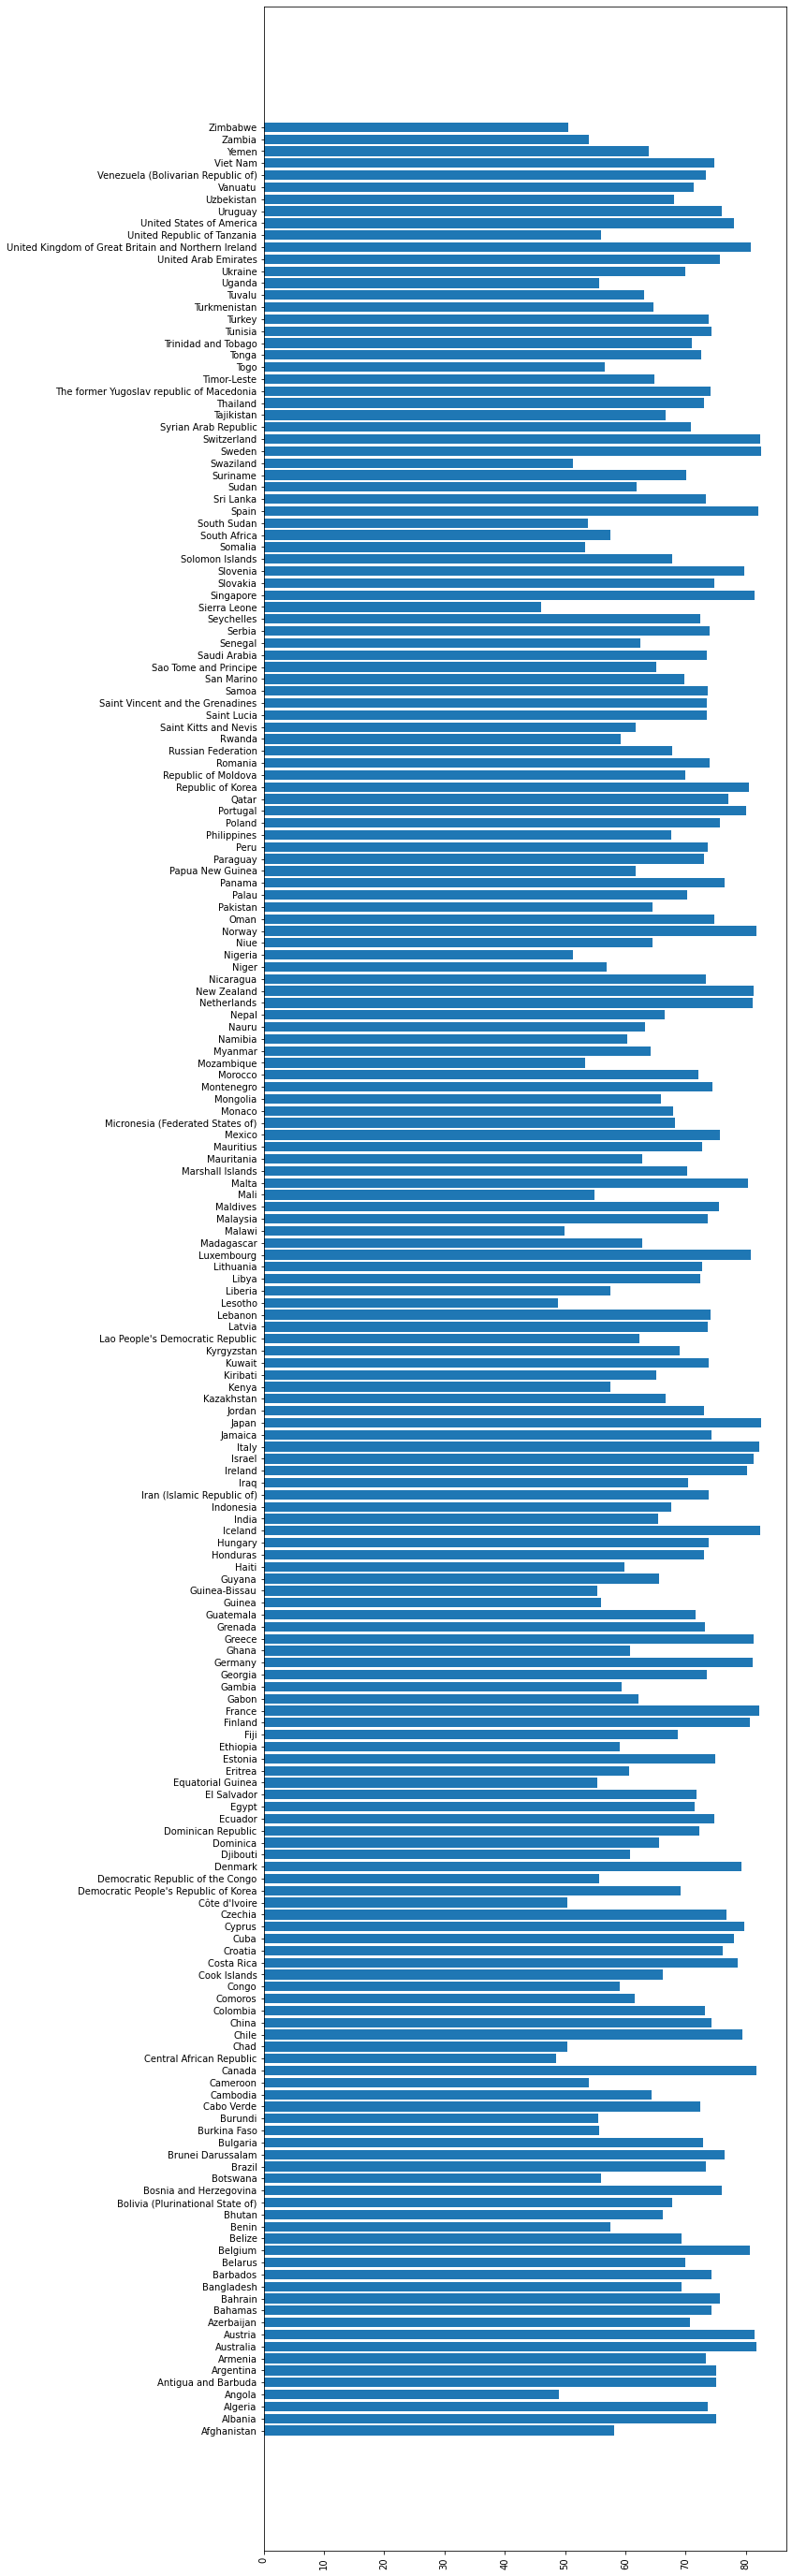

In [157]:
# multivariate analysis of categorical variables vs 'Life expectancy '
plt.figure(figsize=(10,50))
plt.barh(life_data.groupby('Country').mean().index, life_data.groupby('Country')['Life expectancy '].mean())
plt.xticks(rotation= 90)
plt.show()

In [158]:
# Country does not seem like a good feature, there is no real trend here. Lets
# try multivariate analysis

# See which variables are strongly related to 'Life Expectancy
life_data.corr()['Life expectancy ']




Year                               0.168309
Life expectancy                    1.000000
Adult Mortality                   -0.695730
infant deaths                     -0.196197
Alcohol                            0.400068
percentage expenditure             0.382069
Hepatitis B                        0.247419
Measles                           -0.157298
 BMI                               0.556433
under-five deaths                 -0.222151
Polio                              0.459865
Total expenditure                  0.210843
Diphtheria                         0.474084
 HIV/AIDS                         -0.555929
GDP                                0.435854
Population                        -0.007126
 thinness  1-19 years             -0.476809
 thinness 5-9 years               -0.472485
Income composition of resources    0.690071
Schooling                          0.703409
Name: Life expectancy , dtype: float64

In [160]:
# Looking at the correlation matrix, we select are the variables that have a
# correlation factor with 'Life expectancy ' of ' _ > .5' or '_<-.5' to see
# which variables have strong correlation. These will be the variables that
# will be used for the PCA analysis to see which ones will be ideal for the model.

variables = ['Life expectancy ','Adult Mortality', ' BMI ', ' HIV/AIDS', 'Income composition of resources', 'Schooling']
life_data[variables].corr()['Life expectancy ']

Life expectancy                    1.000000
Adult Mortality                   -0.695730
 BMI                               0.556433
 HIV/AIDS                         -0.555929
Income composition of resources    0.690071
Schooling                          0.703409
Name: Life expectancy , dtype: float64

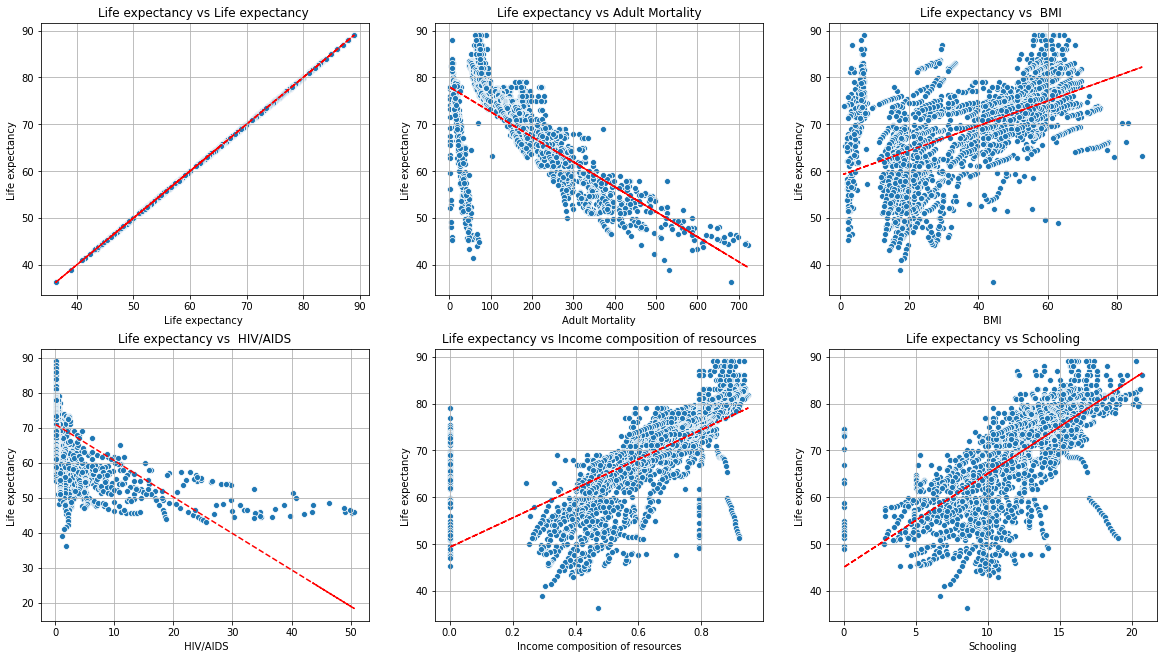

In [161]:
# create scatterplot visualizations for multivariate analysis between 'variables'
# and 'Life expectancy '

plt.figure(figsize=(20,17))
x = 1
for col in variables:
  plt.subplot(3,3,x)
  sns.scatterplot(life_data[col], life_data['Life expectancy '])
  z = np.polyfit(life_data[col], life_data['Life expectancy '], 1)
  p = np.poly1d(z)
  plt.plot(life_data[col], p(life_data[col]), 'r--')
  plt.title('Life expectancy vs {}'.format(col))
  plt.grid(True)
  x = x + 1

# From the plots we see that all of these have either strong correlation with 
# 'Life expectancy ', but not each other, now we proceed to PCA to see which
# features will be selected

In [164]:
# Using the variables we found above, lets test their correlation to one another.
# This will be important as closely related variables cannot be used in PCA

life_data[variables].corr()

# we can see that some of the variables are highly related to one another
# making them poor candidates for our model. Lets remove the ones that have strong
# correlation to other variables


,Life expectancy,Adult Mortality,BMI,HIV/AIDS,Income composition of resources,Schooling
Life expectancy,1.000000,-0.695730,0.556433,-0.555929,0.690071,0.703409
Adult Mortality,-0.695730,1.000000,-0.383224,0.523245,-0.440536,-0.430481
BMI,0.556433,-0.383224,1.000000,-0.243181,0.461457,0.488210
HIV/AIDS,-0.555929,0.523245,-0.243181,1.000000,-0.246793,-0.216817
Income composition of resources,0.690071,-0.440536,0.461457,-0.246793,1.000000,0.803152
Schooling,0.703409,-0.430481,0.488210,-0.216817,0.803152,1.000000


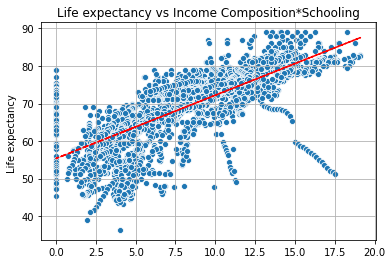

In [180]:
#Two of our variables are strongly correlated to one another, 'Income composition of resources'
#and 'Schooling'. These two varaibles might need to be removed from our model as they
#are stronly correlated to each other, but also happen to be the two varibles most
#strongly correlated to our target variable, Life Expectancy. That being said we can 
#create a new variable that reflects the data from these two columns.
combined_data = life_data['Schooling']*life_data['Income composition of resources']

sns.scatterplot(combined_data, life_data['Life expectancy '])
z = np.polyfit(combined_data, life_data['Life expectancy '], 1)
p = np.poly1d(z)
plt.plot(combined_data, p(combined_data), 'r--')
plt.title('Life expectancy vs Income Composition*Schooling')
plt.grid(True)

# We have successfully combined Schooling and Income composition of resources
variables.remove('Schooling')
variables.remove('Income composition of resources')
variables.append('Schooling * Income Composition')
life_data['Schooling * Income Composition'] = combined_data

In [185]:
# Lets see the correlations of our updated data
life_data[variables].corr()

,Life expectancy,Adult Mortality,BMI,HIV/AIDS,Schooling * Income Composition
Life expectancy,1.000000,-0.695730,0.556433,-0.555929,0.736707
Adult Mortality,-0.695730,1.000000,-0.383224,0.523245,-0.464847
BMI,0.556433,-0.383224,1.000000,-0.243181,0.507451
HIV/AIDS,-0.555929,0.523245,-0.243181,1.000000,-0.255537
Schooling * Income Composition,0.736707,-0.464847,0.507451,-0.255537,1.000000


In [199]:
# Variables now contains all the variables needed for our model. We can also use PCA to 
# reduce the dimensionality further.
life_data_reduced = life_data[variables]

X = StandardScaler().fit_transform(life_data[variables])
Xt = X.T
Cx = np.cov(Xt)
eig_val, eig_vec = np.linalg.eig(Cx)
print(eig_val)
# We see that only one of our eigenvector components have an eigen value greater
# than 1, its the one we'll keep for our model.
print(eig_vec)

[3.01345452 0.16387648 0.88103959 0.52800679 0.41532503]
[[-0.53694219  0.81699858 -0.01429225 -0.18121078  0.10566353]
 [ 0.46196181  0.24104728 -0.29640898  0.19409861  0.77650173]
 [-0.39510073 -0.08539405 -0.50092513  0.7560443  -0.11863515]
 [ 0.37336607  0.22536666 -0.69423587 -0.3144826  -0.47848187]
 [-0.45030829 -0.46510993 -0.42314066 -0.50890676  0.37796969]]


In [200]:
'''
So after preforming exploratory data analysis we have found Adult Mortality,
BMI, HIV/AIDS, and Schooling*Income composition are the variables that most affect
Life Expectancy and these are the variables that we should use for our model. 
PCA reduces this 5 variable model into 1 variable model, if the need should arise.
'''

'\nSo after preforming exploratory data analysis we have found Adult Mortality,\nBMI, HIV/AIDS, and Schooling*Income composition are the variables that most affect\nLife Expectancy and these are the variables that we should use for our model. \nPCA reduces this 5 variable model into 1 variable model, if the need should arise.\n'